## Python modules

In [1]:
%matplotlib inline

In [2]:
import imageio
import numpy as np
import numpy.random as rd 
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
from pyimzml.ImzMLWriter import ImzMLWriter
from pyimzml.ImzMLParser import ImzMLParser
from copy import deepcopy
from scipy.stats import nbinom, pearsonr
from sklearn.cluster import KMeans
import pandas as pd

## Loading and preparation of the reference image

Load the reference "optical" image: 

In [3]:
mask = imageio.imread('SimulationMask.png')

/tmp/ipykernel_8523/3487602934.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread('SimulationMask.png')


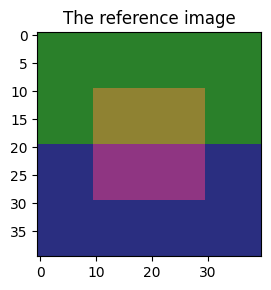

In [4]:
plt.figure(figsize=(3,3))
plt.title('The reference image')
plt.imshow(mask)
plt.tight_layout()
plt.show()

The image contains four regions corresponding to four different colors.   
Parse the image into four `numpy` arrays corresponding to each region:  

In [5]:
region1 = mask[:,:,1] == 128
region2 = mask[:,:,1] == 46
region3 = mask[:,:,1] == 130
region4 = mask[:,:,1] == 53

Generate a two-dimentional array storing the region index for each pixel:  

In [6]:
region_mapping = np.zeros(mask.shape[:2], dtype='int')
for reg_id, reg_value in enumerate([128, 46, 130, 53]):
    region_mapping[mask[:,:,1] == reg_value] = reg_id

Visualize individual regions:

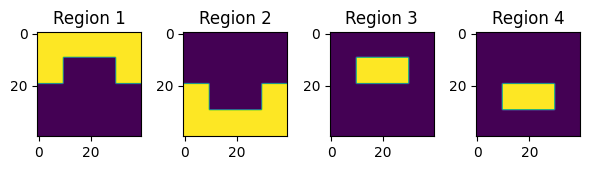

In [7]:
plt.figure(figsize=(6,2))
plt.subplot(141)
plt.title('Region 1')
plt.imshow(region1)
plt.subplot(142)
plt.title('Region 2')
plt.imshow(region2)
plt.subplot(143)
plt.title('Region 3')
plt.imshow(region3)
plt.subplot(144)
plt.title('Region 4')
plt.imshow(region4)
plt.tight_layout()
plt.show()

Show the combined regions:

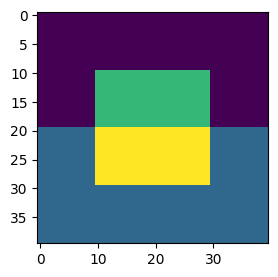

In [8]:
plt.figure(figsize=(3,3))
plt.imshow(region_mapping)
plt.show()

Compute the region areas:

In [9]:
region_areas = [np.sum(region_mapping==i) for i in range(4)]
print('Areas of regions in numbers of pixels:', region_areas)
assert sum(region_areas) == region_mapping.shape[0]*region_mapping.shape[1]

Areas of regions in numbers of pixels: [600, 600, 200, 200]


Generate masks of the top and bottom rectangles and the central square:

In [10]:
enrichment_mask = np.zeros(mask.shape[:2] + (3,), dtype='bool')
enrichment_mask[...,0] = region1 + region3
enrichment_mask[...,1] = region2 + region4
enrichment_mask[...,2] = region3 + region4

# MSI data

Load the image from previous notebook run:

In [1]:
profile_imzml = ImzMLParser('lipid_MSI_profile_mode.imzML')
image = np.zeros((mask.shape[0], mask.shape[1], len(mass_axis)))
for idx, (xcoord,ycoord,zcoord) in enumerate(profile_imzml.coordinates):
    mz, intsy = profile_imzml.getspectrum(idx)
    mz, intsy = np.array(mz), np.array(intsy)
    image[ycoord,xcoord,...] = intsy

NameError: name 'ImzMLParser' is not defined

In [12]:
lipid_names = ['PC(38:1)', 'PA(44:0)', 'PC(38:0)']
lipid_formulas = ['C46H90NO8P', 'C47H93O8P', 'C46H92NO8P']

In [13]:
spectra = [Spectrum(f, adduct='K', threshold=0.001, label=n) for f, n in zip(lipid_formulas, lipid_names)]
for s in spectra:
    s.normalize()

### single ion images for K-means:

## K-means image segmentation

A simple K-means image segmentation based on peak areas:

In [41]:
peak_kmeans_segmentation = np.zeros(integrated_peak_areas.shape)
nclust = 2
for lipid_id, lipid_name in enumerate(lipid_names):
    peak_intensities = integrated_peak_areas[:,:,lipid_id]
    peak_intensities = peak_intensities.reshape((-1,1))
    peak_kmeans = KMeans(n_clusters=nclust)
    region_classification = peak_kmeans.fit_predict(peak_intensities)
    region_classification = region_classification.reshape(40, 40)
    region_classification = np.argsort(np.argsort(peak_kmeans.cluster_centers_.reshape((-1,))))[region_classification]
    peak_kmeans_segmentation[..., lipid_id] = region_classification
    

/home/mciach/Py3Env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mciach/Py3Env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mciach/Py3Env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-means image segmentation based on estimated signals:

In [42]:
masserstein_kmeans_segmentation = np.zeros(integrated_peak_areas.shape)
for lipid_id, lipid_name in enumerate(lipid_names):
    lipid_signals = estimated_lipid_signals[:,:,lipid_id]
    lipid_signals = lipid_signals.reshape((-1,1))
    peak_kmeans = KMeans(n_clusters=nclust)
    region_classification = peak_kmeans.fit_predict(lipid_signals)
    region_classification = region_classification.reshape(40, 40)
    lipid_signals = lipid_signals.reshape((40, 40))
    region_classification = np.argsort(np.argsort(peak_kmeans.cluster_centers_.reshape((-1,))))[region_classification]
    masserstein_kmeans_segmentation[..., lipid_id] = region_classification
    

/home/mciach/Py3Env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mciach/Py3Env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mciach/Py3Env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Comparison of segmentations

In [65]:
nclust = 2

algorithms = ['Peak K-means', 'WS K-means', 'Peak sDGMM', 'WS sDGMM']
accuracy = np.zeros((len(lipid_names), len(algorithms)))
correlation = np.zeros((len(lipid_names), len(algorithms)))

for lipid_id, lipid_name in enumerate(lipid_names):
    # Peak K-means
    region_classification = peak_kmeans_segmentation[..., lipid_id]
    accuracy[lipid_id, 0] = np.mean(region_classification == enrichment_mask[...,lipid_id])
    correlation[lipid_id, 0] = pearsonr(region_classification.flatten(), enrichment_mask[...,lipid_id].flatten())[0]
    # WS K-means
    region_classification = masserstein_kmeans_segmentation[..., lipid_id]
    accuracy[lipid_id, 1] = np.mean(region_classification == enrichment_mask[...,lipid_id])
    correlation[lipid_id, 1] = pearsonr(region_classification.flatten(), enrichment_mask[...,lipid_id].flatten())[0]
    # Peak spatialDGMM
    region_classification = peak_sdgmm_segmentation[..., lipid_id]
    accuracy[lipid_id, 2] = np.mean(region_classification == enrichment_mask[...,lipid_id])
    correlation[lipid_id, 2] = pearsonr(region_classification.flatten(), enrichment_mask[...,lipid_id].flatten())[0]
    # WS spatialDGMM
    region_classification = masserstein_sdgmm_segmentation[..., lipid_id]
    # ws_sdgmm_specificity[lipid_id] = np.sum(region_classification * enrichment_mask[...,lipid_id])/np.sum(enrichment_mask[...,lipid_id])
    accuracy[lipid_id, 3] = np.mean(region_classification == enrichment_mask[...,lipid_id])
    correlation[lipid_id, 3] = pearsonr(region_classification.flatten(), enrichment_mask[...,lipid_id].flatten())[0]

average_accuracy = np.mean(accuracy, axis=0)
average_correlation = np.mean(correlation, axis=0)

Text(40, 20, 'Masserstein\nspatial-DGMM')

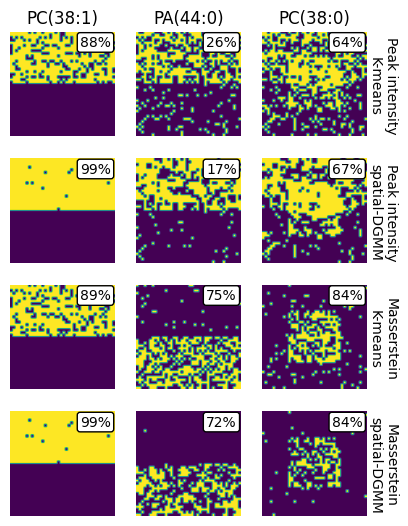

In [66]:
plt.subplots(4, 3, figsize=(4.6,6.3))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(4, 3, 1 + lipid_id)
    plt.title(lipid_name)
    plt.imshow(peak_kmeans_segmentation[..., lipid_id])
    plt.text(38, 1, str(int(100*accuracy[lipid_id, 0]))+'%',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),
            ha='right', va='top')
    plt.axis('off')
    
    plt.subplot(4, 3, 4 + lipid_id)
    plt.imshow(peak_sdgmm_segmentation[..., lipid_id])
    plt.text(38, 1, str(int(100*accuracy[lipid_id, 2]))+'%',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),
            ha='right', va='top')
    plt.axis('off')
    
    plt.subplot(4, 3, 7 + lipid_id)
    plt.imshow(masserstein_kmeans_segmentation[..., lipid_id])
    plt.text(38, 1, str(int(100*accuracy[lipid_id, 1]))+'%',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),
            ha='right', va='top')
    plt.axis('off')
    
    plt.subplot(4, 3, 10 + lipid_id)
    plt.imshow(masserstein_sdgmm_segmentation[..., lipid_id])
    plt.text(38, 1, str(int(100*accuracy[lipid_id, 3]))+'%',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),
            ha='right', va='top')
    plt.axis('off')
    
plt.subplot(4,3,3)
plt.text(40, 20, 'Peak intensity\nK-means', rotation=-90, rotation_mode='anchor', ha='center', va='bottom')
plt.subplot(4,3,6)
plt.text(40, 20, 'Peak intensity\nspatial-DGMM', rotation=-90, rotation_mode='anchor', ha='center', va='bottom')
plt.subplot(4,3,9)
plt.text(40, 20, 'Masserstein\nK-means', rotation=-90, rotation_mode='anchor', ha='center', va='bottom')
plt.subplot(4,3,12)
plt.text(40, 20, 'Masserstein\nspatial-DGMM', rotation=-90, rotation_mode='anchor', ha='center', va='bottom')
